In [1]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        print("Found GPU:", gpu)
else:
    print("No GPU detected")

Found GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
base_dir = "C:\/Users\/khors\/Downloads\/DeepFake Face Recognition\/Datasets\/dfdc_train_part_00"

real_dir = os.path.join(base_dir, 'real')
fake_dir = os.path.join(base_dir, 'fake')

real_frames = os.path.join(real_dir, "real_frames")
fake_frames = os.path.join(fake_dir, "fake_frames")

real_faces = os.path.join(real_dir, "real_faces")
fake_faces = os.path.join(fake_dir, "fake_faces")

real_faces_dir = os.path.join(real_dir, "real_faces")
fake_faces_dir = os.path.join(fake_dir, "fake_faces")

train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")

In [5]:
train_data_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

validation_data_generator = ImageDataGenerator(rescale=1./255)

In [6]:
train_generator = train_data_generator.flow_from_directory(train_dir,
                                                    target_size=(224, 224),
                                                    batch_size=20,
                                                    class_mode='binary',
                                                          shuffle=False)

test_generator = validation_data_generator.flow_from_directory(test_dir,
                                                  target_size=(224, 224),
                                                  batch_size=20,
                                                  class_mode='binary',
                                                  shuffle=False)

Found 10118 images belonging to 2 classes.
Found 2531 images belonging to 2 classes.


In [7]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def create_roc_curve(y_true, y_pred):
    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    return plt

In [8]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def create_confusion_matrix(test_generator):
    # Predict the classes for the test data
    y_pred = model.predict(test_generator)
    y_pred_classes = (y_pred > 0.5).astype(int)
    
    # Get the true labels for the test data
    y_true = test_generator.classes
    
    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred_classes)
    
    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    return plt

In [9]:
from sklearn.metrics import classification_report

def create_classification_report(test_generator):
    # Get the model predictions on the test data
    y_pred = model.predict(test_generator)
    
    # Convert the predicted probabilities to class labels (0 or 1)
    y_pred_binary = (y_pred > 0.5).astype(int)
    
    # Get the true labels from the test data generator
    y_true = test_generator.classes
    
    return classification_report(y_true, y_pred_binary)

In [10]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

In [11]:
# Load the InceptionV3 model pre-trained on ImageNet data
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

In [12]:
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

In [13]:
# Add custom top layers for your specific task
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Add a global spatial average pooling layer
x = Dense(1024, activation='relu')(x)  # Add a fully-connected layer
predictions = Dense(1, activation='sigmoid')(x)  # Output layer for binary classification

model = Model(inputs=base_model.input, outputs=predictions)

In [14]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [15]:
from tensorflow.keras.callbacks import EarlyStopping

with tf.device("/GPU:0"):
    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=20,
        validation_data=test_generator,
        validation_steps=len(test_generator),
        callbacks=[EarlyStopping(patience=3, restore_best_weights=True)]
    )

Epoch 1/20
506/506 [==============================] - 127s 240ms/step - loss: 0.7457 - accuracy: 0.5769 - val_loss: 0.6268 - val_accuracy: 0.6578
Epoch 2/20
506/506 [==============================] - 109s 215ms/step - loss: 0.6443 - accuracy: 0.6413 - val_loss: 0.6074 - val_accuracy: 0.6752
Epoch 3/20
506/506 [==============================] - 109s 216ms/step - loss: 0.6195 - accuracy: 0.6527 - val_loss: 0.5958 - val_accuracy: 0.6760
Epoch 4/20
506/506 [==============================] - 108s 214ms/step - loss: 0.6356 - accuracy: 0.6571 - val_loss: 0.6270 - val_accuracy: 0.6448
Epoch 5/20
506/506 [==============================] - 109s 215ms/step - loss: 0.5969 - accuracy: 0.6842 - val_loss: 0.5622 - val_accuracy: 0.6966
Epoch 6/20
506/506 [==============================] - 109s 214ms/step - loss: 0.5965 - accuracy: 0.6737 - val_loss: 0.5412 - val_accuracy: 0.7298
Epoch 7/20
506/506 [==============================] - 109s 215ms/step - loss: 0.5559 - accuracy: 0.7120 - val_loss: 0.5258 -

In [16]:
model.save("C:\/Users\/khors\/Downloads\/DeepFake Face Recognition\/Saved Models\/InceptionNet.h5")

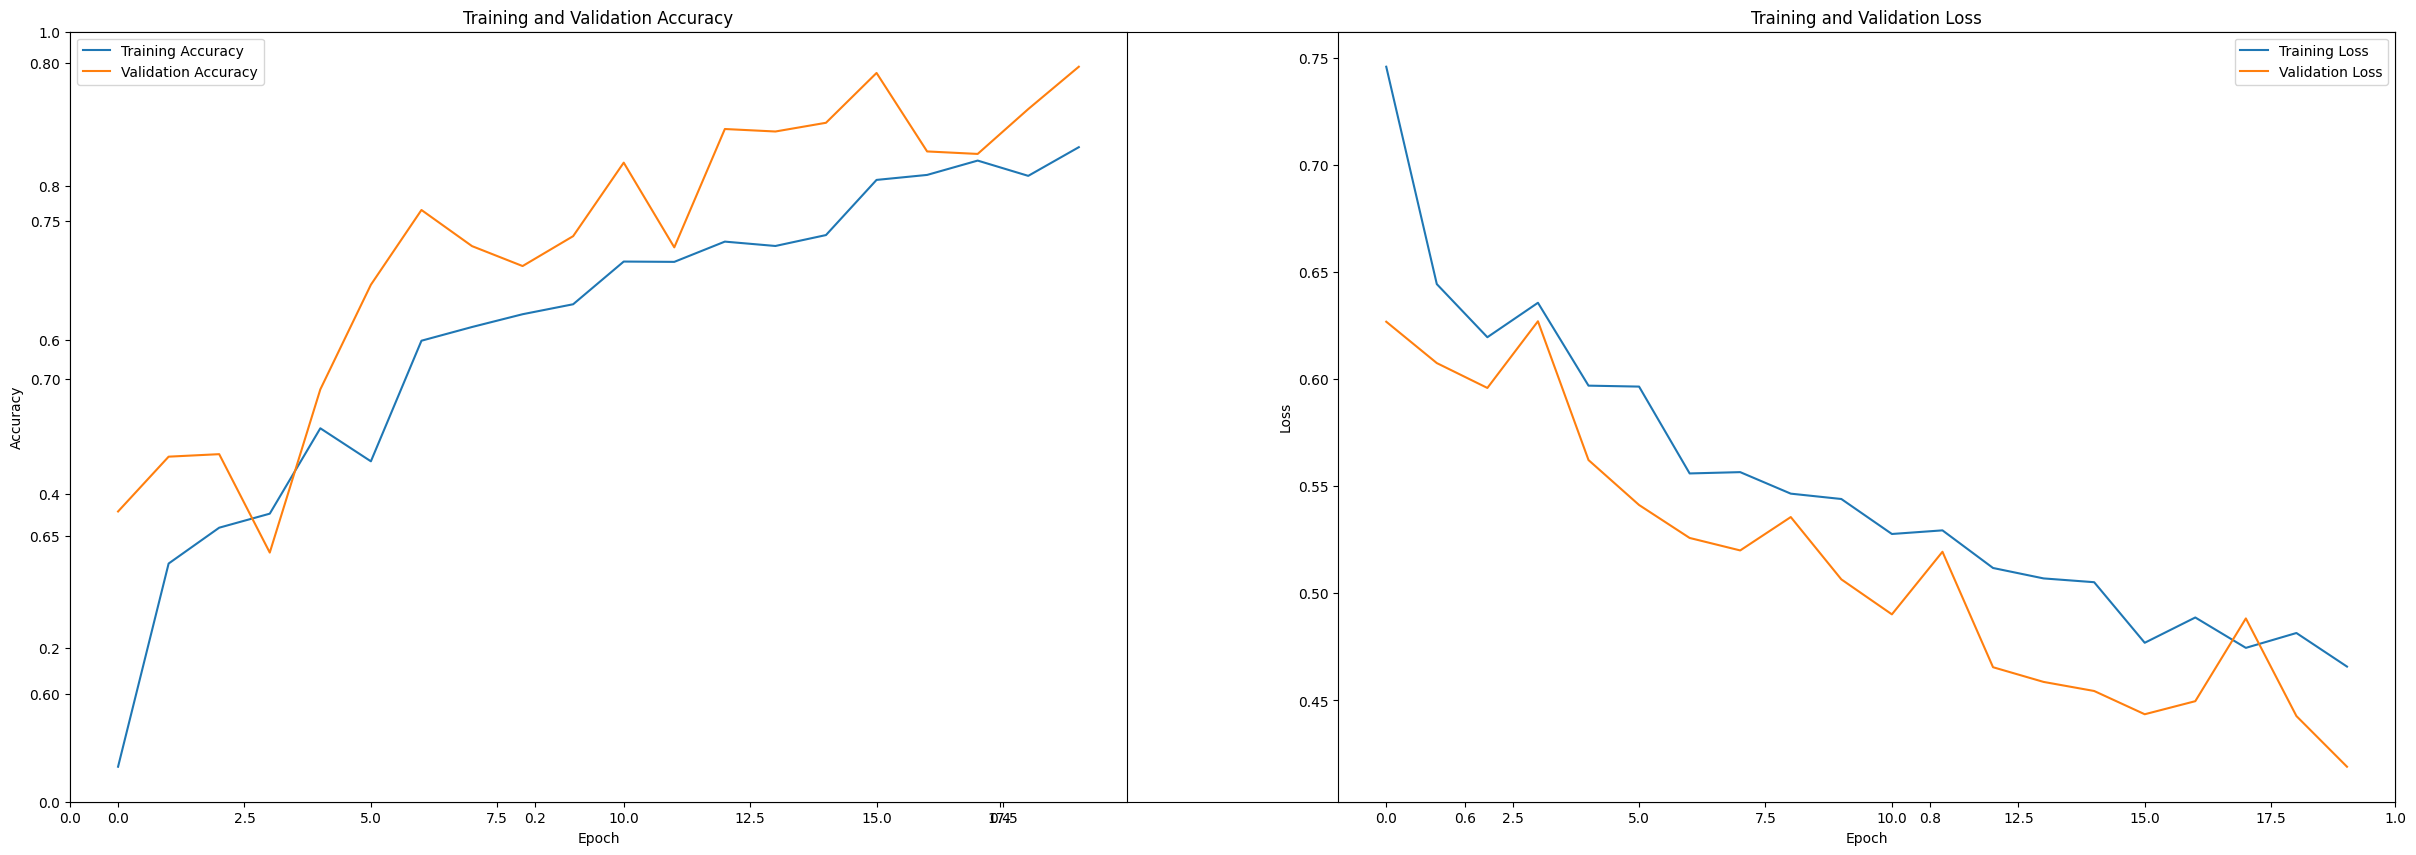

In [17]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']   #if you are usinf tf version 1.x then use 'acc' instead of 'accuracy'
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

fig = plt.subplots(figsize=(30, 10))

plt.subplot(1, 2, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])

plt.subplot(1, 2, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])

plt.show()

In [18]:
# from keras.models import load_model
# savedModel=load_model("C:\/Users\/khors\/Downloads\/DeepFake Face Recognition\/Saved Models\/InceptionNet.h5")

In [19]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy}, Test Loss: {test_loss}")

127/127 [==============================] - 5s 41ms/step - loss: 0.4191 - accuracy: 0.7989
Test Accuracy: 0.7988936901092529, Test Loss: 0.41909259557724


In [20]:
y_pred = model.predict(test_generator)

127/127 [==============================] - 6s 38ms/step


In [21]:
print(y_pred)

[[0.07240671]
 [0.01461808]
 [0.05149656]
 ...
 [0.37315646]
 [0.38232708]
 [0.4804725 ]]


In [22]:
 # Get the model predictions on the test data
y_pred = model.predict(test_generator)

# Convert the predicted probabilities to class labels (0 or 1)
y_pred_binary = (y_pred > 0.5).astype(int)

# Get the true labels from the test data generator
y_true = test_generator.classes

127/127 [==============================] - 5s 38ms/step


In [23]:
print(y_pred_binary[10:20], y_true[10:20])

[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]] [0 0 0 0 0 0 0 0 0 0]


127/127 [==============================] - 5s 38ms/step


<module 'matplotlib.pyplot' from 'C:\\Users\\khors\\miniconda3\\envs\\test\\lib\\site-packages\\matplotlib\\pyplot.py'>

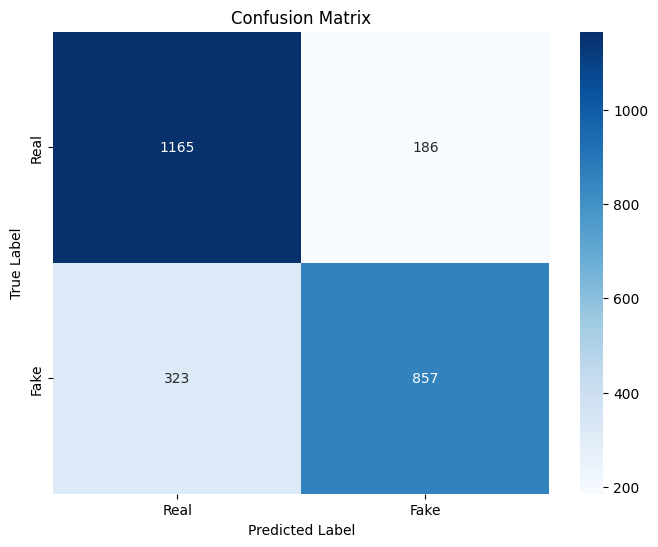

In [24]:
create_confusion_matrix(test_generator)

In [25]:
print(create_classification_report(test_generator))

127/127 [==============================] - 5s 38ms/step
              precision    recall  f1-score   support

           0       0.78      0.86      0.82      1351
           1       0.82      0.73      0.77      1180

    accuracy                           0.80      2531
   macro avg       0.80      0.79      0.80      2531
weighted avg       0.80      0.80      0.80      2531



127/127 [==============================] - 5s 39ms/step


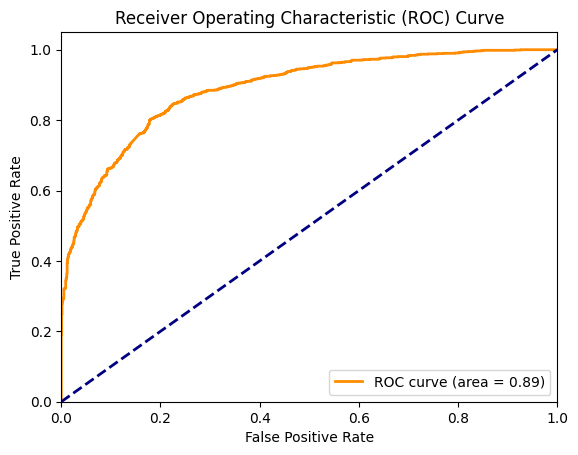

In [26]:
# Get true labels
y_true = test_generator.classes

# Get predicted probabilities
y_pred = model.predict(test_generator)
y_pred = y_pred.flatten()

# Adjust decision threshold
threshold = 0.1
y_pred_binary = (y_pred > threshold).astype(int)

y_pred_log = -np.log(y_pred)

# Apply scaling to bring probabilities within a reasonable range
y_pred_scaled = y_pred * 1e6  # Adjust the scaling factor as needed

create_roc_curve(y_true, y_pred_scaled).show()

### Regularization 

In [27]:
from keras.regularizers import l2
from keras.layers import Dropout

# Define the base InceptionNet model
base_model = InceptionV3(weights='imagenet', include_top=False)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False
    
# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully-connected layer with L2 regularization
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.001))(x)

# Add dropout regularization
x = Dropout(0.5)(x)

# Add another fully-connected layer with L2 regularization
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)

# Add dropout regularization
x = Dropout(0.5)(x)

# Output layer with softmax activation for multi-class classification
predictions = Dense(1, activation='sigmoid')(x)

# Combine the base model and custom layers to create the final model
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping

with tf.device("/GPU:0"):
    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=20,
        validation_data=test_generator,
        validation_steps=len(test_generator),
        callbacks=[EarlyStopping(patience=3, restore_best_weights=True)]
    )

Epoch 1/20
506/506 [==============================] - 113s 216ms/step - loss: 1.6293 - accuracy: 0.5614 - val_loss: 1.0421 - val_accuracy: 0.5377
Epoch 2/20
506/506 [==============================] - 108s 214ms/step - loss: 0.9383 - accuracy: 0.5731 - val_loss: 0.8071 - val_accuracy: 0.6381
Epoch 3/20
506/506 [==============================] - 108s 214ms/step - loss: 0.7757 - accuracy: 0.5897 - val_loss: 0.7225 - val_accuracy: 0.6650
Epoch 4/20
506/506 [==============================] - 109s 215ms/step - loss: 0.7121 - accuracy: 0.6195 - val_loss: 0.6869 - val_accuracy: 0.6586
Epoch 5/20
506/506 [==============================] - 108s 214ms/step - loss: 0.6812 - accuracy: 0.6211 - val_loss: 0.6792 - val_accuracy: 0.6100
Epoch 6/20
506/506 [==============================] - 109s 215ms/step - loss: 0.6698 - accuracy: 0.6322 - val_loss: 0.6527 - val_accuracy: 0.6867
Epoch 7/20
506/506 [==============================] - 109s 214ms/step - loss: 0.6611 - accuracy: 0.6310 - val_loss: 0.6349 -

In [28]:
model.save("C:\/Users\/khors\/Downloads\/DeepFake Face Recognition\/Saved Models\/InceptionNet_Regularization.h5")

In [29]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy}, Test Loss: {test_loss}")

127/127 [==============================] - 5s 41ms/step - loss: 0.5901 - accuracy: 0.7317
Test Accuracy: 0.7317265868186951, Test Loss: 0.5900952219963074


127/127 [==============================] - 6s 38ms/step


<module 'matplotlib.pyplot' from 'C:\\Users\\khors\\miniconda3\\envs\\test\\lib\\site-packages\\matplotlib\\pyplot.py'>

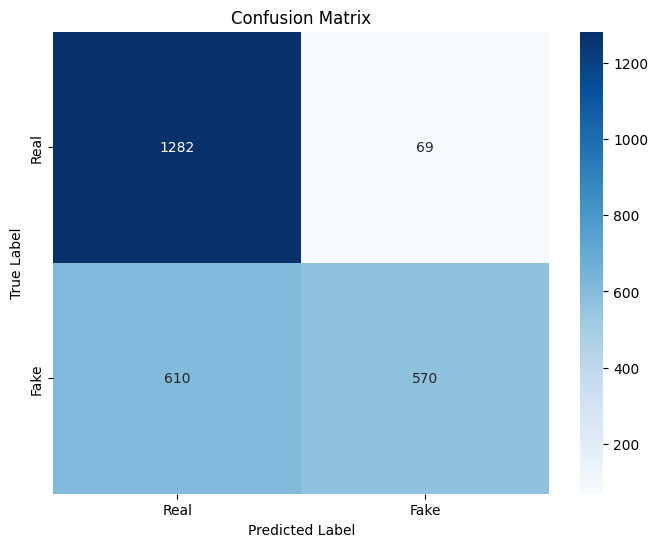

In [30]:
create_confusion_matrix(test_generator)

127/127 [==============================] - 5s 39ms/step


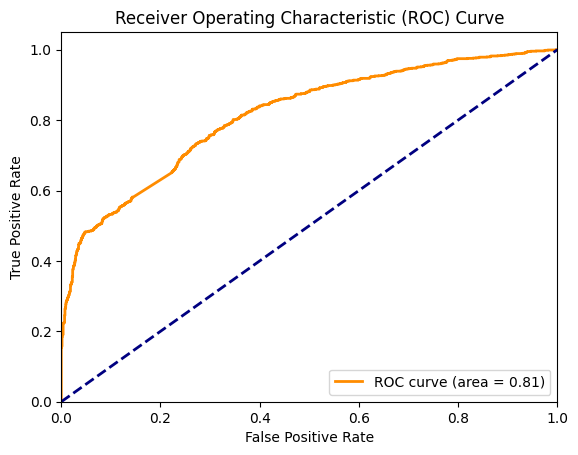

In [31]:
# Get true labels
y_true = test_generator.classes

# Get predicted probabilities
y_pred = model.predict(test_generator)
y_pred = y_pred.flatten()

# Adjust decision threshold
threshold = 0.1
y_pred_binary = (y_pred > threshold).astype(int)

y_pred_log = -np.log(y_pred)

# Apply scaling to bring probabilities within a reasonable range
y_pred_scaled = y_pred * 1e6  # Adjust the scaling factor as needed

create_roc_curve(y_true, y_pred_scaled).show()

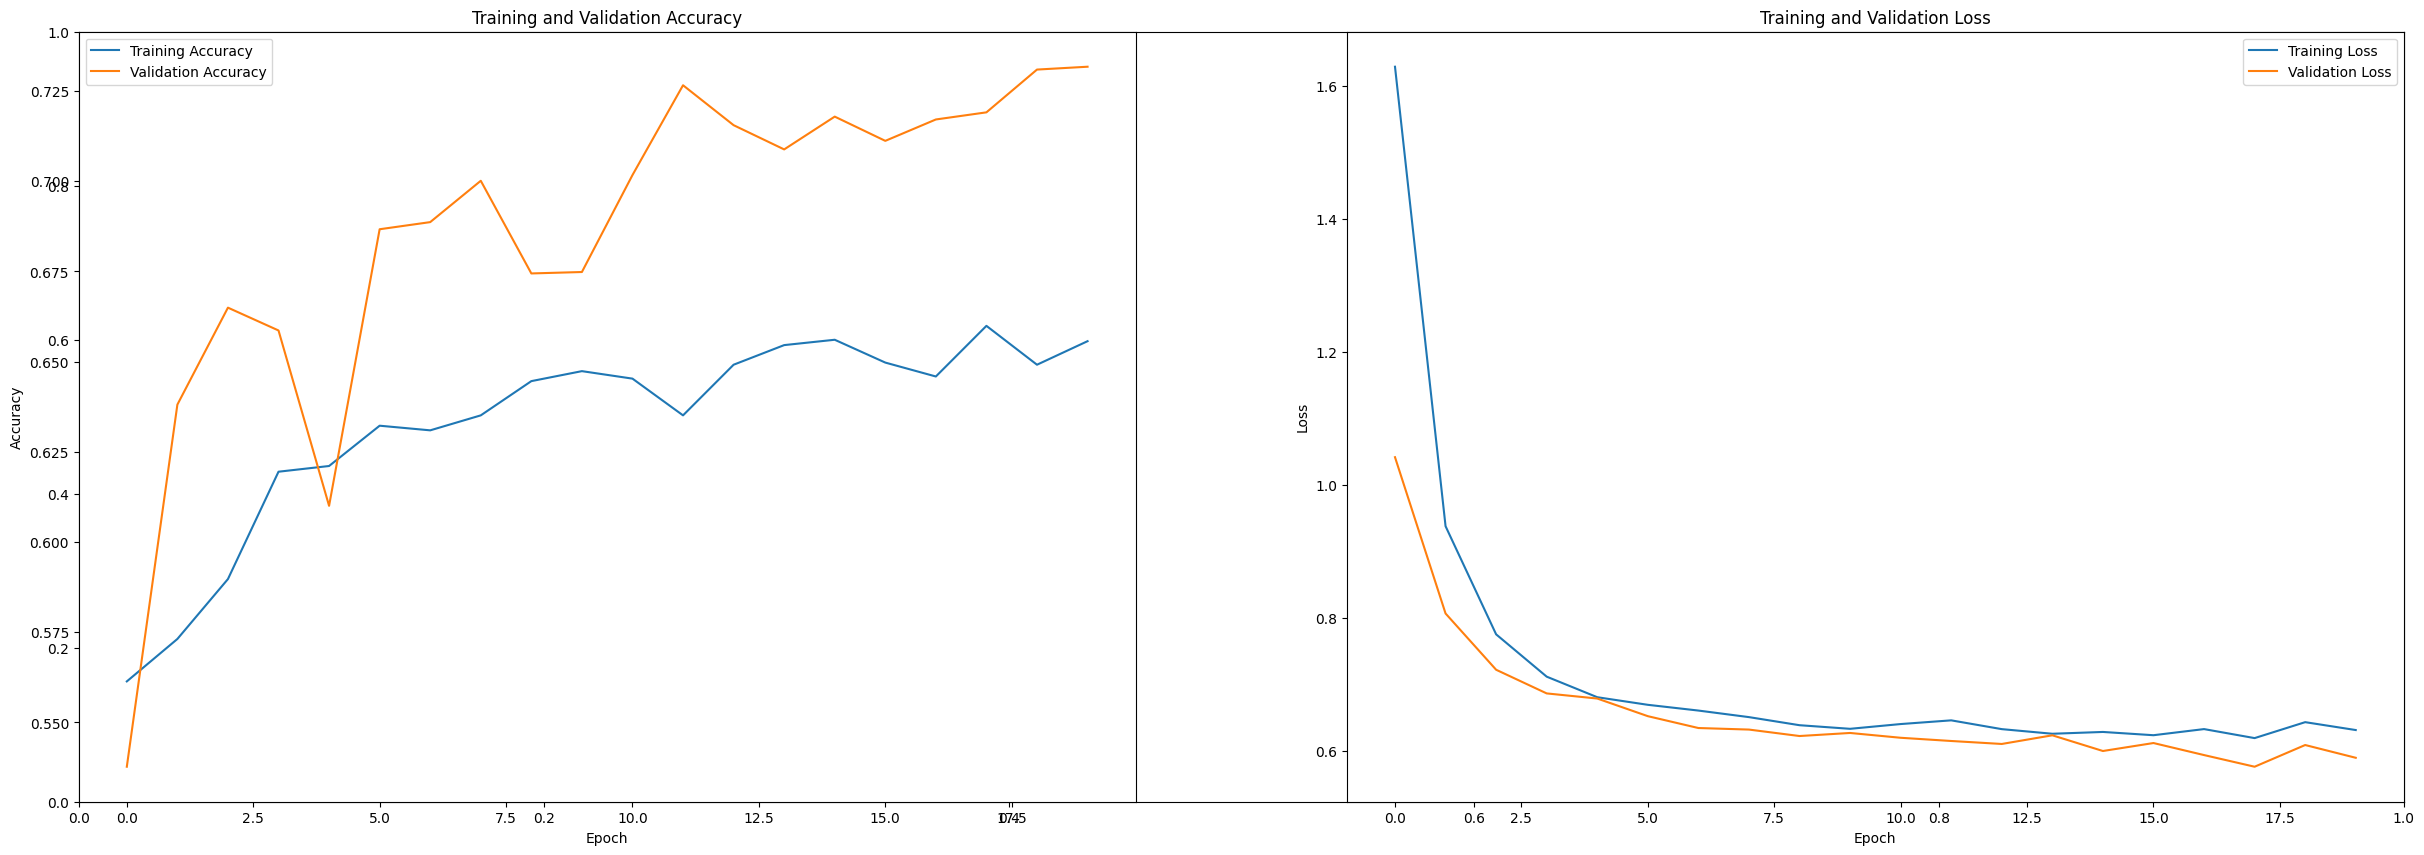

In [32]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']   #if you are usinf tf version 1.x then use 'acc' instead of 'accuracy'
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

fig = plt.subplots(figsize=(30, 10))

plt.subplot(1, 2, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])

plt.subplot(1, 2, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])

plt.show()